# Massively parallel Transition Path Sampling

## Notebook 3: Analyze TPS simulation

This is the third of a series of example notebooks on massively parallel transition path sampling. Obviously you need to have run the TPS simulation in the first notebook to analyze it here (you do not necesarily have to continue it in the second notebook).

We will first have a look at the training of the model during the simulation and also at its ability to predict the shooting outcomes accurately (using the difference between expected and actual outcomes). We will perform a relative input importance analysis to see which input descriptors influence the reaction coordinate models prediction the most (these are the important coordinates determining the committor and describing the reaction). Finaly we will project the density of transitions to the $\psi$,$\phi$ plane and (hopefully) observe that all the Markov chains converged to the same density.

**This notebook should be run on a multi-core workstation preferably with a GPU**, otherwise you will have a very long coffee break and a very hot laptop.

**Required knowledge/recommended reading:** This notebooks assumes some familarity with the `asyncmd` (namely the [gromacs] engine and TrajectoryFunctionWrapper classes). Please see the example notebooks in `asyncmd` for an introduction.

## Imports and set working directory

In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as mdt
import MDAnalysis as mda
import aimmd
import aimmd.distributed as aimmdd
import asyncmd
import asyncmd.trajectory as asynctraj
from asyncmd import Trajectory

/home/tb/hejung/.conda/envs/aimmd_distributed_devel/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.
Tensorflow/Keras not available


In [3]:
# setup working directory (this should be the same as in the previous notebook)

scratch_dir = "/homeloc/scratch/aimmd_distributed/"
#scratch_dir = "."

workdir = os.path.join(scratch_dir, "TransitionPathSampling_ala")

## Open the storage in read only mode

In [4]:
storage = aimmd.Storage(os.path.join(workdir, "storage.h5"), mode="r")

Opening storage without write intent, asyncmd trajectory value caching will not be performed in h5py (but most likely as seperate npz files).


## Load the model, trainset and brain

We do not realy need them but it can be most comfortable to access the simulation results via the brain (e.g. the order of accepted MC steps globaly).

In [5]:
model = storage.rcmodels["model_to_continue_with"]

aimmd storage passed as density collector cache file is open in read-only mode. No appending will be possible.


In [6]:
trainset = storage.load_trainset()

In [7]:
tasks = [aimmdd.pathsampling.TrainingTask(model=model, trainset=trainset),
         aimmdd.pathsampling.SaveTask(storage=storage, model=model, trainset=trainset),
         aimmdd.pathsampling.DensityCollectionTask(model=model,
                                                   first_collection=100,
                                                   recreate_interval=500,
                                                   interval=10
                                                   ),
         ]

In [8]:
brain = storage.load_brain(model=model, tasks=tasks)

In [9]:
brain.total_steps

10009

## Plot the training of the model during the simulation

### Learning rate vs Monte Carlo step

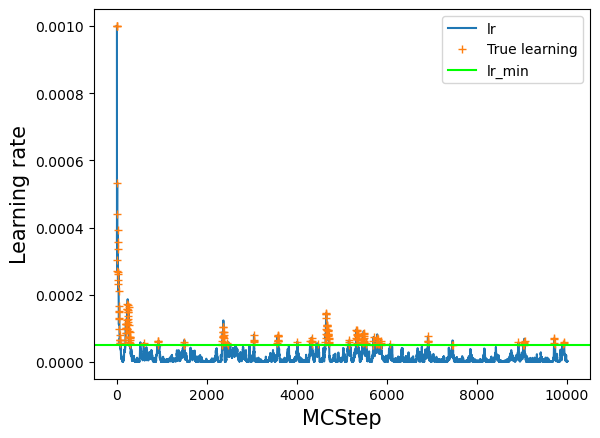

In [10]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

### Loss vs Monte Carlo step

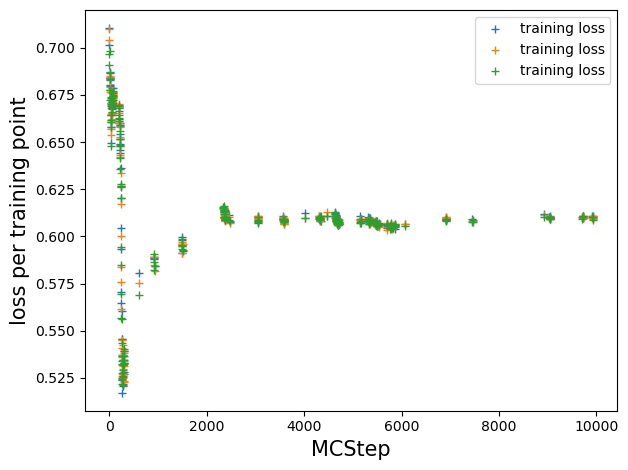

In [11]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

### Cumulative counts of expected, generated and accepted transitions vs Monte Carlo step

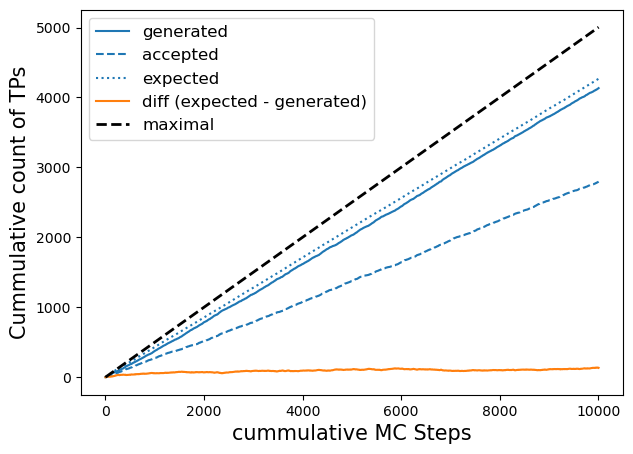

In [12]:
# plot efficiency, expected efficiency and accepts
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)
fig, axs = plt.subplots(figsize=(7, 5))

n_steps = -1  # up to which step number to plot

p_ex = np.array(model.expected_p)[:n_steps]

l, = axs.plot(np.cumsum(trainset.transitions[:n_steps]), label='generated');
axs.plot(np.cumsum(brain.accepts[:n_steps]), c=l.get_color(), ls='--', label='accepted');
axs.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
axs.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions[:n_steps]), label='diff (expected - generated)')
axs.plot(np.linspace(0., len(trainset[:n_steps])/2., len(trainset[:n_steps])), c='k', ls='--', label='maximal', lw=2)
axs.legend(fontsize=12);
axs.set_ylabel('Cummulative count of TPs', size=15)
axs.set_xlabel('cummulative MC Steps', size=15);

## Relative input importance analysis

We will use the hipr class to perform the input importance analysis, it randomizes each coordinate one at a time and calculates the resulting losses.

In [13]:
hipr = aimmd.analysis.HIPRanalysis(model, trainset)

In [14]:
# do 25 repetitions, return mean and std
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(25)

### Plot the loss increase (relative importance) of each coordinate

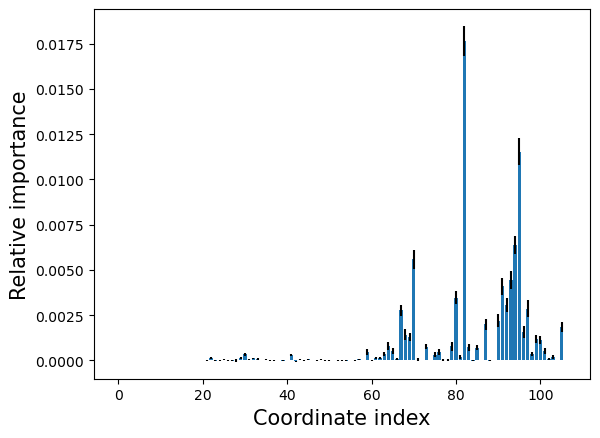

In [15]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

### Print out the most important coordinates

We try our best to print out the most relevant coordinates in a human understandeable form.

In [16]:
# what are the most important contributors?
max_idxs = np.argsort(loss_diffs)[::-1]

# import the function used to generate the internal coordinate representation for the molecule
from state_funcs_mda import generate_atomgroups_for_ic

# and use it to get lists of pairs (distances), triples (angles) and quadruples ([pseudo-]dihedrals)
u = mda.Universe("gmx_infiles/ala_300K_amber99sb-ildn.tpr", "gmx_infiles/conf.gro",
                 refresh_offsets=True, tpr_resid_from_one=True)
molecule = u.select_atoms('protein')
pairs, triples, quadruples = generate_atomgroups_for_ic(molecule)

def pprint_atom(at):
    """Helper function to print atom information in a nice way."""
    ret = f"Atom {at.ix+1}:"
    if hasattr(at, "name"):
        ret += f" {at.name}"
    if hasattr(at, "resname"):
        ret += f" in residue {at.resname}"
    if hasattr(at, "resid"):
        ret += f" (resid {at.resid})"
    return ret

# now use all of this to print the most relevant coordinates in a remotely human understandable fashion
print('reference loss:', hipr_plus_losses[-1])
for idx in max_idxs[:6]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_plus_losses[idx], f" (loss diff= {hipr_plus_losses[idx] - hipr_plus_losses[-1]})")
    if idx < len(pairs[0]):
        print(f"bond between: {pprint_atom(pairs[0][idx])} and {pprint_atom(pairs[1][idx])}")
        continue
    idx -= len(pairs[0])
    if idx < len(triples[0]):
        print(f"angle between {pprint_atom(triples[0][idx])}, {pprint_atom(triples[1][idx])} and {pprint_atom(triples[2][idx])}")
        continue
    idx -= len(triples[0])
    if idx % 2 == 0:
        st = "sinus"
    else:
        st = "cosinus"
    st += f" of dihedral between {pprint_atom(quadruples[0][idx // 2])}, {pprint_atom(quadruples[1][idx // 2])}, {pprint_atom(quadruples[2][idx // 2])}"
    st += f" and {pprint_atom(quadruples[3][idx // 2])}."
    print(st)

reference loss: 0.6074080934580752

loss for idx 82:  0.6250527474491707  (loss diff= 0.017644653991095494)
cosinus of dihedral between Atom 7: N in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 15: C in residue ALA (resid 2) and Atom 17: N in residue NME (resid 3).

loss for idx 95:  0.6189378211952993  (loss diff= 0.01152972773722405)
sinus of dihedral between Atom 11: CB in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 15: C in residue ALA (resid 2) and Atom 17: N in residue NME (resid 3).

loss for idx 94:  0.6137949341686233  (loss diff= 0.0063868407105480696)
cosinus of dihedral between Atom 10: HA in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 15: C in residue ALA (resid 2) and Atom 16: O in residue ALA (resid 2).

loss for idx 70:  0.6129932079682973  (loss diff= 0.005585114510222033)
cosinus of dihedral between Atom 5: C in residue ACE (resid 1), Atom 7: N in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2) a

## Analyze the transition path ensemble

We will have a look at the density of transitions and shootin points in the $\psi$, $\phi$ plane and at the transition time distribution. Note that instead of a function projecting the trajectories to the $\psi$, $\phi$ plane, you could use any function that projects configurations to lower dimensional spaces or calculates scalars over whole trajectories (as for the distribution of transition times).

In [17]:
# import a function to project the trajectory data to the ψ, φ plane
from state_funcs_mda import descriptor_func_psi_phi
# wrapp it to make it awaitable
wrapped_psi_phi = asynctraj.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [18]:
# get out all mcstates (sorted by collection so we can compare the collections to each other later below)
# Note that the mcstates contains doubles because the represent the chain of acceppted Monte Carlo steps (in case of a reject we reaccept)
mcstates_by_collection = [[state for state in collection.mcstates()] for collection in storage.mcstep_collections] 

In [19]:
# calculate all ψ,φ values for all transitions for plotting later
accepted_steps_psi_phi_by_collection = []
for collection_states in mcstates_by_collection:
    accepted_steps_psi_phi_by_collection.append(await asyncio.gather(*(wrapped_psi_phi(s.path) for s in collection_states)))

### Plot the transition path time distribution

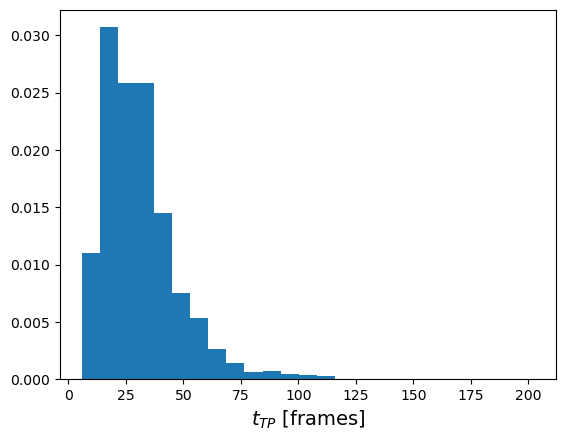

In [20]:
# plot transition path time distribution
fig, axs = plt.subplots()

t_TP_in_frames = [len(s.path) for s in collection_states for collection_states in mcstates_by_collection]

axs.hist(t_TP_in_frames, bins=25, density=True)
axs.set_xlabel("$t_{TP}$ [frames]", size=14);

### Plot the density of transitions in the $\psi$, $\phi$ plane, $p(\psi,\phi|TP)$

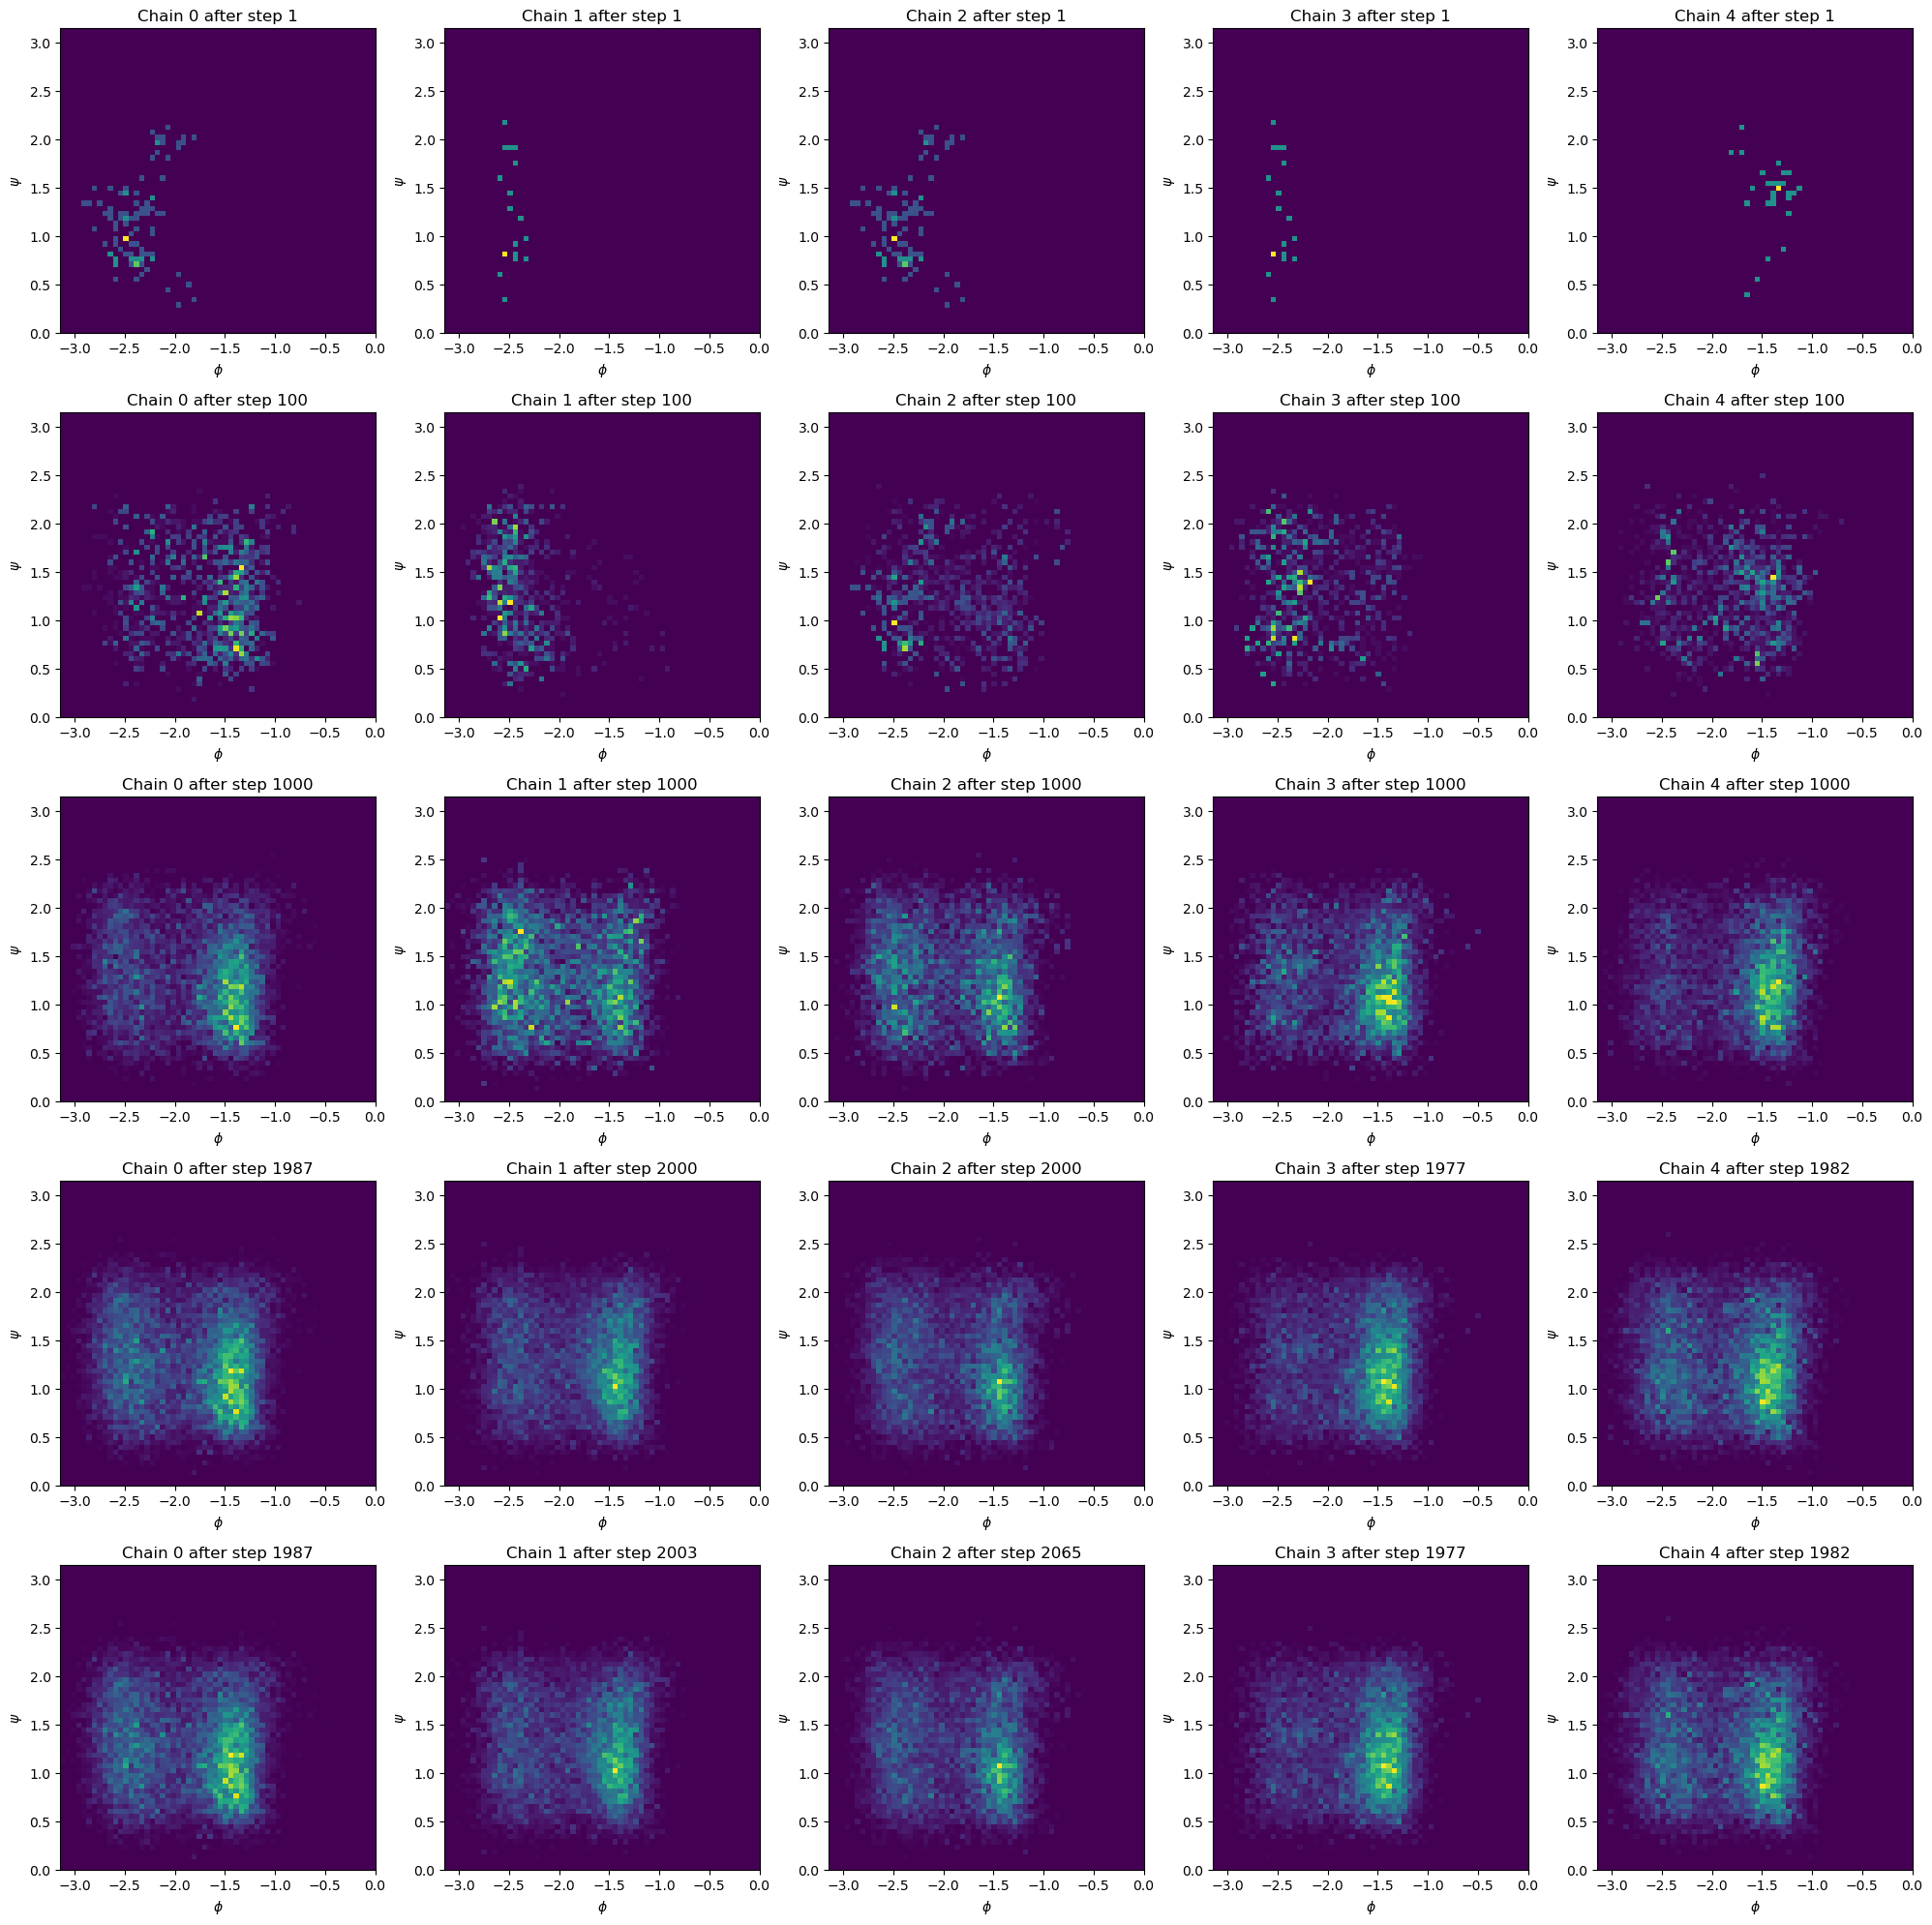

In [21]:
steps_done = [1, 100, 1000, 2000, None]  # the None gives us the last step for all chains

fig, axs = plt.subplots(ncols=len(storage.mcstep_collections), nrows=len(steps_done),
                        figsize=(len(storage.mcstep_collections)*4, 4*len(steps_done)))

for max_step, axs_array in zip(steps_done, axs):
    for c_idx, ax in enumerate(axs_array):
        ax.set_title(f"Chain {c_idx} after step {len(accepted_steps_psi_phi_by_collection[c_idx][:max_step])}")
        ax.set_xlabel("$\phi$")
        ax.set_ylabel("$\psi$")
        plot_data = np.concatenate(accepted_steps_psi_phi_by_collection[c_idx][:max_step], axis=0)
        ax.hist2d(plot_data[:, 1], plot_data[:, 0], bins=(60, 60), range=((-np.pi, 0), (0, np.pi)), density=True)
        ax.set_xlim(-np.pi, 0)
        ax.set_ylim(0, np.pi)

fig.tight_layout()

### Calculate $p(\psi,\phi|TP)$ for all chains together

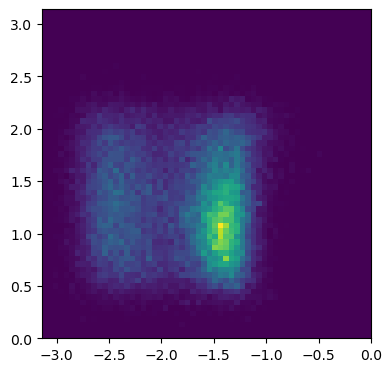

In [22]:
fig, axs = plt.subplots(figsize=(4, 4))

all_psi_phi = []
for i in range(len(brain.samplers)):
    all_psi_phi.append(np.concatenate(accepted_steps_psi_phi_by_collection[i], axis=0))

all_psi_phi = np.concatenate(all_psi_phi, axis=0)
combined_density, xedges, yedges = np.histogram2d(all_psi_phi[:, 1], all_psi_phi[:, 0], bins=(60, 60), range=((-np.pi, 0), (0, np.pi)), density=True)

axs.imshow(combined_density.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower")
ax.set_xlabel("$\phi$")
ax.set_ylabel("$\psi$")
    
fig.tight_layout()

### Calculate how much each Markov chain differs from the mean

In [23]:
from scipy.spatial import distance

In [25]:
histo_per_collection = []
for i in range(len(brain.samplers)):
    plot_data = np.concatenate(accepted_steps_psi_phi_by_collection[i], axis=0)
    h, xedges, yedges = np.histogram2d(plot_data[:, 1], plot_data[:, 0], bins=(60, 60), range=((-np.pi, 0), (0, np.pi)), density=True)
    histo_per_collection.append(h)

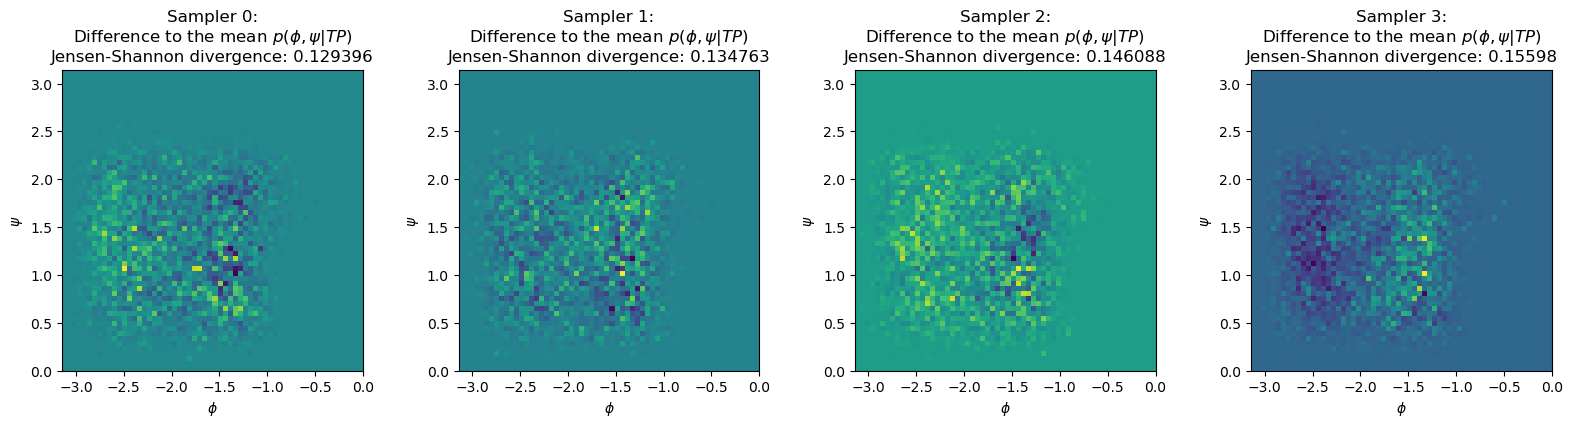

In [26]:
fig, axs = plt.subplots(ncols=4, figsize=(4*4, 4))

for cidx, (h, ax) in enumerate(zip(histo_per_collection, axs)):
    q = h.T
    p = combined_density.T
    mapp = ax.imshow(q - p, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower")
    ax.set_title(f"Sampler {cidx}:\nDifference to the mean $p(\phi, \psi| TP)$\nJensen-Shannon divergence: {round(distance.jensenshannon(p.flatten(), q.flatten()), 6)}")
    ax.set_xlabel("$\phi$")
    ax.set_ylabel("$\psi$")
    
fig.tight_layout()

In [27]:
storage.close()